In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.optimize import minimize, differential_evolution
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [11]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=7)
    return df

df = load_data("Реклама_в_поиске_по_запросу_футболка_белая_женская.xlsx")
print(f" Загружено {len(df)} записей")

 Загружено 100 записей


In [12]:
df

,Артикул,Дата создания,Выручка,Заказы,Средняя цена без СПП,Средний чек,Коэффициент демпинга,Остатки на конец периода,Дней в наличии,Дней отсутствовал,...,Рейтинг,Количество отзывов на конец периода,Поставщик,Бренд,Предмет,Позиция в выдаче,Стоимость за 1000 показов,Тип рекламы,Буст на позицию,Буст с позиции
0,321555743,2025-02-01,6249720,6651,956.77,939.67,1.79,10708,30,0,...,4.7,1305,1308994,312112270,Футболки,1,2000,c,1,799
1,35477396,2021-07-29,3160006,2645,1186.57,1194.71,0.00,2493,30,0,...,4.9,5357,98741,311147988,Футболки,2,1500,c,2,324
2,96318847,2022-09-29,8069644,6354,1280.77,1270.01,0.84,6277,30,0,...,4.8,5865,824000,8165119,Футболки,3,1450,c,3,312
3,159089242,2023-05-24,7607974,6278,1219.00,1211.85,0.59,10738,30,0,...,4.8,3650,57423,311580832,Футболки,4,1470,c,4,319
4,33562590,2021-07-06,2899442,2380,1209.53,1218.25,0.00,3504,30,0,...,4.9,17000,98741,311147988,Футболки,5,1600,c,5,535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,439074842,2025-06-19,635298,585,1133.92,1085.98,4.23,589,25,5,...,4.8,40,69043,96551,Футболки,96,350,b,96,799
96,164713912,2023-07-01,924154,698,1315.97,1324.00,0.00,1571,30,0,...,4.8,966,1283238,310800937,Футболки,97,460,c,97,1076
97,291721200,2024-11-29,2483984,2337,1096.07,1062.89,3.03,583,30,0,...,4.7,1036,4168945,96551,Футболки,98,400,b,98,1161
98,412643081,2025-06-05,112465,95,1174.23,1183.84,0.00,166,29,1,...,5.0,3,4421867,0,Футболки,99,750,c,99,6520


Предобработка данных

In [13]:
def preprocess_data(df, target='Буст с позиции'):

    df_clean = df.copy()

    # Удаление
    cols_to_drop = [
        'Дата создания', 'Название', 'Поставщик', 'Бренд', 'Предмет',
        'Тип рекламы', 'Буст на позицию', 'Позиция в выдаче',
        'Стоимость за 1000 показов'
    ]
    cols_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
    df_clean = df_clean.drop(columns=cols_to_drop)

    initial_len = len(df_clean)
    df_clean = df_clean.dropna(subset=[target])
    print(f"   Удалено {initial_len - len(df_clean)} строк с пропусками")

    initial_len = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"   Удалено {initial_len - len(df_clean)} дубликатов")

    # Обработка выбросов в целевой переменной
    Q1 = df_clean[target].quantile(0.25)
    Q3 = df_clean[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    initial_len = len(df_clean)
    df_clean = df_clean[(df_clean[target] >= lower_bound) & (df_clean[target] <= upper_bound)]
    print(f"   Удалено {initial_len - len(df_clean)} выбросов в целевой переменной")

    # Удаление сильно коррелирующих признаков
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    corr_matrix = df_clean[numeric_cols].corr()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.95:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    # Удаляем один из коррелирующих признаков
    cols_to_remove = set()
    for col1, col2 in high_corr_pairs:
        if col1 != target and col2 != target:
            corr1 = abs(df_clean[col1].corr(df_clean[target]))
            corr2 = abs(df_clean[col2].corr(df_clean[target]))
            if corr1 < corr2:
                cols_to_remove.add(col1)
            else:
                cols_to_remove.add(col2)

    df_clean = df_clean.drop(columns=list(cols_to_remove))
    print(f"   Удалено {len(cols_to_remove)} сильно коррелирующих признаков")

    print(f"Осталось {len(df_clean)} записей и {len(df_clean.columns)} признаков")
    return df_clean

In [16]:
df_processed = preprocess_data(df)
print("\n Структура данных после предобработки:")
print(df_processed.info())

# Показываем доступные столбцы
print("\n Доступные столбцы после предобработки:")
for i, col in enumerate(df_processed.columns, 1):
    print(f"   {i}. {col}")

# Анализ целевой переменной
print("\n Анализ целевой переменной 'Буст с позиции':")
print(f"   Среднее значение: {df_processed['Буст с позиции'].mean():.2f}")
print(f"   Медиана: {df_processed['Буст с позиции'].median():.2f}")
print(f"   Стандартное отклонение: {df_processed['Буст с позиции'].std():.2f}")
print(f"   Минимум: {df_processed['Буст с позиции'].min():.2f}")
print(f"   Максимум: {df_processed['Буст с позиции'].max():.2f}")


   Удалено 0 строк с пропусками
   Удалено 0 дубликатов
   Удалено 13 выбросов в целевой переменной
   Удалено 6 сильно коррелирующих признаков
Осталось 87 записей и 12 признаков

 Структура данных после предобработки:
<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Артикул                              87 non-null     int64  
 1   Средний чек                          87 non-null     float64
 2   Коэффициент демпинга                 87 non-null     float64
 3   Остатки на конец периода             87 non-null     int64  
 4   Дней в наличии                       87 non-null     int64  
 5   Среднее кол-во заказов при наличии   87 non-null     float64
 6   Выручка в день при наличии товаров   87 non-null     float64
 7   Общая скидка без СПП                 87 non-null     float64
 8   Упущенные заказы  

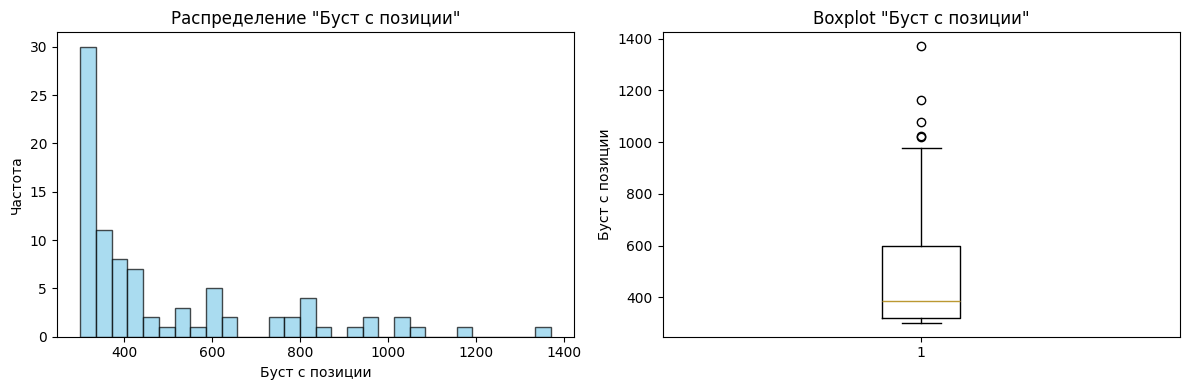

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_processed['Буст с позиции'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение "Буст с позиции"')
plt.xlabel('Буст с позиции')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.boxplot(df_processed['Буст с позиции'])
plt.title('Boxplot "Буст с позиции"')
plt.ylabel('Буст с позиции')
plt.tight_layout()
plt.show()

Подготовка к обучению

In [21]:
X = df_processed.drop(columns=['Буст с позиции'])
y = df_processed['Буст с позиции']

print(f" Признаки для моделирования:\n {list(X.columns)}")


 Признаки для моделирования:
 ['Артикул', 'Средний чек', 'Коэффициент демпинга', 'Остатки на конец периода', 'Дней в наличии', 'Среднее кол-во заказов при наличии', 'Выручка в день при наличии товаров', 'Общая скидка без СПП', 'Упущенные заказы', 'Рейтинг', 'Количество отзывов на конец периода']


In [22]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

print(f" Размер обучающей выборки: {len(X_train)}")
print(f" Размер тестовой выборки: {len(X_test)}")


 Размер обучающей выборки: 65
 Размер тестовой выборки: 22


Обучение

In [23]:
models =  { 'XGBoost': XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
}

In [24]:
results = {}
for name, model in models.items():
    print(f"\nОбучение модели: {name}")

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    try:
        cv_scores = cross_val_score(model, X_scaled, y, cv=3, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except:
        cv_mean = r2_test
        cv_std = 0

    results[name] = {
        'model': model,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }

    print(f"   MAE (train): {mae_train:.2f}")
    print(f"   MAE (test): {mae_test:.2f}")
    print(f"   R² (train): {r2_train:.4f}")
    print(f"   R² (test): {r2_test:.4f}")
    print(f"   RMSE (test): {rmse_test:.2f}")
    print(f"   CV R²: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")



Обучение модели: XGBoost
   MAE (train): 2.24
   MAE (test): 178.04
   R² (train): 0.9998
   R² (test): -0.4300
   RMSE (test): 257.39
   CV R²: -0.6383 (+/- 0.6699)

Обучение модели: Random Forest
   MAE (train): 103.43
   MAE (test): 151.19
   R² (train): 0.7067
   R² (test): -0.0001
   RMSE (test): 215.25
   CV R²: -0.2995 (+/- 0.1587)


In [27]:
best_model_name = max(results.keys(), key=lambda x: results[x]['r2_test'])
best_model = results[best_model_name]['model']
print(f"\n Лучшая модель: {best_model_name}")


 Лучшая модель: Random Forest


Анализ важности признаков

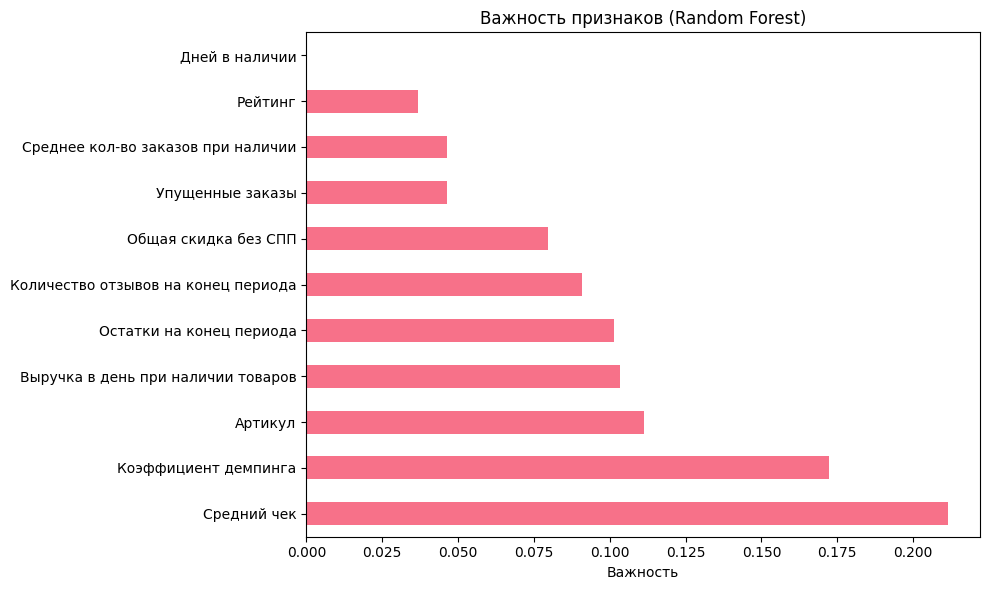


Топ-5 важных признаков:
   1. Средний чек: 0.2115
   2. Коэффициент демпинга: 0.1721
   3. Артикул: 0.1113
   4. Выручка в день при наличии товаров: 0.1034
   5. Остатки на конец периода: 0.1016


In [28]:
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh')
    plt.title(f'Важность признаков ({best_model_name})')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()

    print("\nТоп-5 важных признаков:")
    for i, (feature, importance) in enumerate(importances.head().items(), 1):
        print(f"   {i}. {feature}: {importance:.4f}")

Оптимизация параметров для улучшения позиции

In [29]:
def predict_position(model, scaler, feature_names, input_values):
    """Прогнозирует позицию товара на основе параметров"""
    input_df = pd.DataFrame([input_values], columns=feature_names)
    input_scaled = scaler.transform(input_df)
    return model.predict(input_scaled)[0]

In [33]:
def optimize_product_position(model, scaler, feature_names, current_values,
                            controllable_features, bounds, current_actual_rank, optimization_method='differential_evolution'):
    """
    Оптимизирует параметры товара для улучшения позиции
    Args:
        model: обученная модель
        scaler: нормализатор
        feature_names: названия признаков
        current_values: текущие значения параметров
        controllable_features: список признаков, которые можно изменять
        bounds: границы для каждого изменяемого признака
        current_actual_rank: фактическая текущая позиция товара
        optimization_method: метод оптимизации
    """

    print(f"\n Начинаем оптимизацию позиции товара")
    current_predicted_position = predict_position(model, scaler, feature_names, current_values)
    print(f" Фактическая позиция: {current_actual_rank:.0f}")
    print(f" Предсказанная позиция: {current_predicted_position:.0f}")
    def objective_function(params):
        # Создаем новый вектор параметров
        new_values = current_values.copy()
        for i, feature in enumerate(controllable_features):
            new_values[feature] = params[i]

        # Прогнозируем новую позицию
        predicted_position = predict_position(model, scaler, feature_names, new_values)
        return predicted_position

    # Подготовка границ для оптимизации
    optimization_bounds = [bounds[feature] for feature in controllable_features]

    # Запуск оптимизации
    if optimization_method == 'differential_evolution':
        result = differential_evolution(
            objective_function,
            optimization_bounds,
            maxiter=500,
            popsize=10,
            seed=42
        )
    else:
        result = minimize(
            objective_function,
            x0=[current_values[feature] for feature in controllable_features],
            bounds=optimization_bounds,
            method='L-BFGS-B'
        )

    # Получаем оптимальные параметры
    optimal_params = current_values.copy()
    for i, feature in enumerate(controllable_features):
        optimal_params[feature] = result.x[i]

    # Прогнозируем оптимальную позицию
    optimal_predicted_position = predict_position(model, scaler, feature_names, optimal_params)

    # Рассчитываем улучшение относительно фактической позиции
    improvement_from_actual = current_actual_rank - optimal_predicted_position
    improvement_from_predicted = current_predicted_position - optimal_predicted_position
    improvement_percent = (improvement_from_actual/current_actual_rank)*100 if current_actual_rank > 0 else 0

    print(f"\n РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
    print(f"   Фактическая позиция: {current_actual_rank:.0f}")
    print(f"   Предсказанная позиция (текущая): {current_predicted_position:.0f}")
    print(f"   Предсказанная позиция (оптимальная): {optimal_predicted_position:.0f}")
    print(f"   Улучшение от фактической позиции: {improvement_from_actual:.0f} позиций")
    print(f"   Улучшение от предсказанной позиции: {improvement_from_predicted:.0f} позиций")
    print(f"   Процент улучшения от фактической: {improvement_percent:.1f}%")

    # Проверяем качество улучшения
    if improvement_from_actual > 0 and improvement_percent >= 2.0:
        print(f"\n ОПТИМИЗАЦИЯ УСПЕШНА!")
        print("Рекомендуемые изменения параметров:")
        for feature in controllable_features:
            old_val = current_values[feature]
            new_val = optimal_params[feature]
            change = new_val - old_val
            if old_val != 0:
                change_pct = (change / old_val) * 100
                print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f}, {change_pct:+.1f}%)")
            else:
                print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f})")

        print(f"\n ОЖИДАЕМЫЙ РЕЗУЛЬТАТ:")
        print(f"   Текущая фактическая позиция: {current_actual_rank:.0f}")
        print(f"   Ожидаемая позиция после оптимизации: {optimal_predicted_position:.0f}")
        print(f"   Ожидаемое улучшение: {improvement_from_actual:.0f} позиций")

    elif improvement_from_actual > 0 and improvement_percent < 2.0:
        print(f"\nНЕБОЛЬШОЕ УЛУЧШЕНИЕ НАЙДЕНО ({improvement_percent:.1f}%)")
        print("Пробуем альтернативные стратегии оптимизации...")

        # Альтернативная стратегия 1: Более агрессивные изменения
        print(f"\nАЛЬТЕРНАТИВНАЯ СТРАТЕГИЯ 1: Более агрессивные изменения")
        aggressive_bounds = {}
        for feature in controllable_features:
            if feature == 'Средняя цена без СПП':
                current_price = current_values[feature]
                aggressive_bounds[feature] = (current_price * 0.5, current_price * 0.9)  # Снижение на 10-50%
            elif feature == 'Общая скидка без СПП':
                current_discount = current_values[feature]
                aggressive_bounds[feature] = (current_discount, min(current_discount + 30, 95))  # Увеличение до 30%
            elif feature == 'Коэффициент демпинга':
                aggressive_bounds[feature] = (0, 15)  # От 0 до 15
            elif feature == 'Рейтинг':
                current_rating = current_values[feature]
                aggressive_bounds[feature] = (current_rating, min(current_rating + 1.0, 5.0))  # Улучшение до 1.0 балла
            elif feature == 'Остатки на конец периода':
                current_stock = current_values[feature]
                aggressive_bounds[feature] = (current_stock, current_stock * 5)  # Увеличение в 5 раз
            else:
                aggressive_bounds[feature] = bounds[feature]

        # Запускаем агрессивную оптимизацию
        aggressive_optimization_bounds = [aggressive_bounds[feature] for feature in controllable_features]
        aggressive_result = differential_evolution(
            objective_function,
            aggressive_optimization_bounds,
            maxiter=1000,
            popsize=20,
            seed=42
        )

        aggressive_optimal_params = current_values.copy()
        for i, feature in enumerate(controllable_features):
            aggressive_optimal_params[feature] = aggressive_result.x[i]

        aggressive_optimal_position = predict_position(model, scaler, feature_names, aggressive_optimal_params)
        aggressive_improvement = current_actual_rank - aggressive_optimal_position
        aggressive_improvement_percent = (aggressive_improvement/current_actual_rank)*100 if current_actual_rank > 0 else 0

        print(f"   Агрессивная оптимизация:")
        print(f"   - Ожидаемая позиция: {aggressive_optimal_position:.0f}")
        print(f"   - Улучшение: {aggressive_improvement:.0f} позиций ({aggressive_improvement_percent:.1f}%)")

        # Выбираем лучший результат
        if aggressive_improvement_percent > improvement_percent:
            print(f"Агрессивная стратегия дала лучший результат")
            optimal_params = aggressive_optimal_params
            optimal_predicted_position = aggressive_optimal_position
            improvement_from_actual = aggressive_improvement
            improvement_percent = aggressive_improvement_percent

            print("Рекомендуемые изменения параметров (агрессивная стратегия):")
            for feature in controllable_features:
                old_val = current_values[feature]
                new_val = optimal_params[feature]
                change = new_val - old_val
                if old_val != 0:
                    change_pct = (change / old_val) * 100
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f}, {change_pct:+.1f}%)")
                else:
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f})")
        else:
            print(f"Агрессивная стратегия не дала лучшего результата")
            print("Используем исходные рекомендации:")
            for feature in controllable_features:
                old_val = current_values[feature]
                new_val = optimal_params[feature]
                change = new_val - old_val
                if old_val != 0:
                    change_pct = (change / old_val) * 100
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f}, {change_pct:+.1f}%)")
                else:
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f})")

    else:
        print(f"\n УЛУЧШЕНИЕ НЕ НАЙДЕНО")
        print("Пробуем альтернативные стратегии...")

        # Альтернативная стратегия 2: Поиск в противоположном направлении
        print(f"\n АЛЬТЕРНАТИВНАЯ СТРАТЕГИЯ 2: Поиск в противоположном направлении")

        # Инвертируем границы для некоторых параметров
        inverted_bounds = {}
        for feature in controllable_features:
            if feature == 'Средняя цена без СПП':
                current_price = current_values[feature]
                inverted_bounds[feature] = (current_price * 1.1, current_price * 1.5)  # Увеличение цены
            elif feature == 'Общая скидка без СПП':
                current_discount = current_values[feature]
                inverted_bounds[feature] = (max(current_discount - 20, 0), current_discount)  # Уменьшение скидки
            elif feature == 'Коэффициент демпинга':
                inverted_bounds[feature] = (10, 20)  # Высокий демпинг
            else:
                inverted_bounds[feature] = bounds[feature]

        # Запускаем инвертированную оптимизацию
        inverted_optimization_bounds = [inverted_bounds[feature] for feature in controllable_features]
        inverted_result = differential_evolution(
            objective_function,
            inverted_optimization_bounds,
            maxiter=500,
            popsize=15,
            seed=42
        )

        inverted_optimal_params = current_values.copy()
        for i, feature in enumerate(controllable_features):
            inverted_optimal_params[feature] = inverted_result.x[i]

        inverted_optimal_position = predict_position(model, scaler, feature_names, inverted_optimal_params)
        inverted_improvement = current_actual_rank - inverted_optimal_position

        print(f"   Инвертированная оптимизация:")
        print(f"   - Ожидаемая позиция: {inverted_optimal_position:.0f}")
        print(f"   - Улучшение: {inverted_improvement:.0f} позиций")

        if inverted_improvement > 0:
            print(f"   Инвертированная стратегия дала положительный результат")
            optimal_params = inverted_optimal_params
            optimal_predicted_position = inverted_optimal_position
            improvement_from_actual = inverted_improvement

            print("Рекомендуемые изменения параметров (инвертированная стратегия):")
            for feature in controllable_features:
                old_val = current_values[feature]
                new_val = optimal_params[feature]
                change = new_val - old_val
                if old_val != 0:
                    change_pct = (change / old_val) * 100
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f}, {change_pct:+.1f}%)")
                else:
                    print(f"   {feature}: {old_val:.2f} → {new_val:.2f} ({change:+.2f})")
        else:
            print(f"    Инвертированная стратегия не дала положительного результата")
            print("Возможные причины:")
            print("   - Модель не обучена достаточно хорошо")
            print("   - Товар уже находится в оптимальной позиции")
            print("   - Нужны другие параметры для оптимизации")
            print("   - Требуется переобучение модели на новых данных")

    return optimal_params, optimal_predicted_position, improvement_from_actual, current_actual_rank



Выбор товара для оптимизации

In [36]:
print("\n ВЫБОР ТОВАРА ДЛЯ ОПТИМИЗАЦИИ")
print("=" * 50)

# Показываем доступные товары
print(" Доступные товары в датасете:")
print(f"   Всего товаров: {len(df_processed)}")
print(f"   Диапазон позиций: от {df_processed['Буст с позиции'].min():.0f} до {df_processed['Буст с позиции'].max():.0f}")
print("   Варианты выбора:")
print("   1. Случайный товар (по умолчанию)")
print("   2. Товар с худшей позицией (максимальный потенциал улучшения)")
print("   3. Товар со средней позицией")
print("   4. Конкретный товар по артикулу")



 ВЫБОР ТОВАРА ДЛЯ ОПТИМИЗАЦИИ
 Доступные товары в датасете:
   Всего товаров: 87
   Диапазон позиций: от 301 до 1371


In [37]:
print("\n Топ-10 товаров с лучшими позициями:")
# Выбираем только те столбцы, которые точно есть в данных
available_columns = ['Артикул', 'Буст с позиции']
if 'Средняя цена без СПП' in df_processed.columns:
    available_columns.append('Средняя цена без СПП')
if 'Рейтинг' in df_processed.columns:
    available_columns.append('Рейтинг')

top_products = df_processed.nsmallest(10, 'Буст с позиции')[available_columns]
for i, (idx, row) in enumerate(top_products.iterrows(), 1):
    price_info = f", Цена: {row['Средняя цена без СПП']:.0f}" if 'Средняя цена без СПП' in available_columns else ""
    rating_info = f", Рейтинг: {row['Рейтинг']:.1f}" if 'Рейтинг' in available_columns else ""
    print(f"   {i}. Артикул: {row['Артикул']:.0f}, Позиция: {row['Буст с позиции']:.0f}{price_info}{rating_info}")



 Топ-10 товаров с лучшими позициями:
   1. Артикул: 32395071, Позиция: 301, Рейтинг: 4.8
   2. Артикул: 101717864, Позиция: 301, Рейтинг: 4.8
   3. Артикул: 336181959, Позиция: 301, Рейтинг: 4.6
   4. Артикул: 64000093, Позиция: 301, Рейтинг: 4.8
   5. Артикул: 242710131, Позиция: 301, Рейтинг: 4.9
   6. Артикул: 262714775, Позиция: 302, Рейтинг: 4.8
   7. Артикул: 30143139, Позиция: 302, Рейтинг: 4.8
   8. Артикул: 215737385, Позиция: 304, Рейтинг: 4.9
   9. Артикул: 250903809, Позиция: 304, Рейтинг: 4.7
   10. Артикул: 242268327, Позиция: 304, Рейтинг: 4.7


In [38]:
print("\n Топ-10 товаров с худшими позициями:")
worst_products = df_processed.nlargest(10, 'Буст с позиции')[available_columns]
for i, (idx, row) in enumerate(worst_products.iterrows(), 1):
    price_info = f", Цена: {row['Средняя цена без СПП']:.0f}" if 'Средняя цена без СПП' in available_columns else ""
    rating_info = f", Рейтинг: {row['Рейтинг']:.1f}" if 'Рейтинг' in available_columns else ""
    print(f"   {i}. Артикул: {row['Артикул']:.0f}, Позиция: {row['Буст с позиции']:.0f}{price_info}{rating_info}")


 Топ-10 товаров с худшими позициями:
   1. Артикул: 377492609, Позиция: 1371, Рейтинг: 4.7
   2. Артикул: 291721200, Позиция: 1161, Рейтинг: 4.7
   3. Артикул: 164713912, Позиция: 1076, Рейтинг: 4.8
   4. Артикул: 235861345, Позиция: 1022, Рейтинг: 4.7
   5. Артикул: 349703029, Позиция: 1021, Рейтинг: 5.0
   6. Артикул: 230652953, Позиция: 978, Рейтинг: 4.8
   7. Артикул: 217018199, Позиция: 961, Рейтинг: 4.4
   8. Артикул: 214454547, Позиция: 932, Рейтинг: 4.7
   9. Артикул: 217928255, Позиция: 864, Рейтинг: 4.7
   10. Артикул: 418073251, Позиция: 823, Рейтинг: 4.8


In [51]:
# ===========================================
# ИЗМЕНИТЕ ЭТУ СТРОКУ ДЛЯ ВЫБОРА ТОВАРА:
choice_method = "random"  # Варианты: "random", "worst", "middle", "specific"
# ===========================================
#
# Варианты выбора товара:
# - "random" - случайный товар (каждый раз новый)
# - "worst" - товар с худшей позицией (максимальный потенциал улучшения)
# - "middle" - товар со средней позицией
# - "specific" - конкретный товар по артикулу (укажите артикул ниже)

if choice_method == "random":
    # Случайный товар
    # Можно выбрать случайный товар из определенного диапазона позиций
    # Например, только товары с позициями от 100 до 1000
    min_position = 0  # Минимальная позиция для выбора
    max_position = float('inf')  # Максимальная позиция для выбора (бесконечность = все товары)

    # Фильтруем товары по диапазону позиций
    filtered_df = df_processed[
        (df_processed['Буст с позиции'] >= min_position) &
        (df_processed['Буст с позиции'] <= max_position)
    ]

    if len(filtered_df) > 0:
        example_row = filtered_df.sample(n=1).iloc[0]
        print(f"   Выбран случайный товар из диапазона позиций {min_position}-{max_position}")
    else:
        # Если в диапазоне нет товаров, берем любой
        example_row = df_processed.sample(n=1).iloc[0]
        print(f"   В диапазоне {min_position}-{max_position} нет товаров, выбран случайный")
elif choice_method == "worst":
    # Товар с худшей позицией
    example_row = df_processed.loc[df_processed['Буст с позиции'].idxmax()]
elif choice_method == "middle":
    # Товар со средней позицией
    median_position = df_processed['Буст с позиции'].median()
    example_row = df_processed.iloc[(df_processed['Буст с позиции'] - median_position).abs().argsort()[:1]].iloc[0]
elif choice_method == "specific":
    # Конкретный товар по артикулу
    # ===========================================
    # ИЗМЕНИТЕ ЭТУ СТРОКУ ДЛЯ ВЫБОРА КОНКРЕТНОГО ТОВАРА:
    target_article = 243010262  # ЗАМЕНИТЕ НА НУЖНЫЙ АРТИКУЛ
    # ===========================================
    #
    # Чтобы найти нужный артикул, посмотрите на список товаров выше
    # и скопируйте артикул нужного товара
    example_row = df_processed[df_processed['Артикул'] == target_article].iloc[0]


   Выбран случайный товар из диапазона позиций 0-inf


In [52]:
current_values = example_row.drop('Буст с позиции').to_dict()
current_actual_rank = example_row['Буст с позиции']

In [53]:
print(f"\n ВЫБРАННЫЙ ТОВАР:")
print(f"   Артикул: {example_row['Артикул']:.0f}")
print(f"   Фактическая позиция: {current_actual_rank:.0f}")
print(f"   Предсказанная позиция: {predict_position(best_model, scaler, X.columns, current_values):.0f}")

print("\nТекущие параметры товара:")
for k, v in current_values.items():
    print(f"   {k}: {v:.2f}")

# Определение управляемых параметров и их границ
controllable_features = []
bounds = {}

# Анализируем каждый признак и определяем, можно ли его изменять
for feature in X.columns:
    if feature == 'Артикул':
        continue  # Артикул нельзя изменять

    if feature in ['Заказы', 'Упущенные заказы', 'Количество отзывов на конец периода']:
        # Эти параметры зависят от времени и спроса, их сложно контролировать напрямую
        continue

    if feature == 'Средняя цена без СПП':
        # Цену можно снижать для улучшения позиции
        current_price = current_values[feature]
        bounds[feature] = (current_price * 0.7, current_price * 0.95)  # Снижение на 5-30%
        controllable_features.append(feature)

    elif feature == 'Общая скидка без СПП':
        # Скидку можно увеличивать
        current_discount = current_values[feature]
        bounds[feature] = (current_discount, min(current_discount + 20, 90))  # Увеличение до 20%
        controllable_features.append(feature)

    elif feature == 'Коэффициент демпинга':
        # Демпинг можно контролировать
        bounds[feature] = (0, 10)  # От 0 до 10
        controllable_features.append(feature)

    elif feature == 'Рейтинг':
        # Рейтинг можно улучшать через качество товара
        current_rating = current_values[feature]
        bounds[feature] = (current_rating, min(current_rating + 0.5, 5.0))  # Улучшение до 0.5 балла
        controllable_features.append(feature)

    elif feature == 'Остатки на конец периода':
        # Остатки можно увеличивать
        current_stock = current_values[feature]
        bounds[feature] = (current_stock, current_stock * 3)  # Увеличение в 3 раза
        controllable_features.append(feature)

print(f"\n🔧 Управляемые параметры ({len(controllable_features)}):")
for feature in controllable_features:
    print(f"   {feature}: {bounds[feature]}")


 ВЫБРАННЫЙ ТОВАР:
   Артикул: 349703029
   Фактическая позиция: 1021
   Предсказанная позиция: 768

Текущие параметры товара:
   Артикул: 349703029.00
   Средний чек: 1297.12
   Коэффициент демпинга: 5.71
   Остатки на конец периода: 50.00
   Дней в наличии: 30.00
   Среднее кол-во заказов при наличии: 4.87
   Выручка в день при наличии товаров: 6312.63
   Общая скидка без СПП: 59.53
   Упущенные заказы: 11.00
   Рейтинг: 5.00
   Количество отзывов на конец периода: 33.00

🔧 Управляемые параметры (4):
   Коэффициент демпинга: (0, 10)
   Остатки на конец периода: (50.0, 150.0)
   Общая скидка без СПП: (59.53, 79.53)
   Рейтинг: (5.0, 5.0)


Запускаем оптимизацию


 Начинаем оптимизацию позиции товара
 Фактическая позиция: 1021
 Предсказанная позиция: 768

 РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:
   Фактическая позиция: 1021
   Предсказанная позиция (текущая): 768
   Предсказанная позиция (оптимальная): 579
   Улучшение от фактической позиции: 442 позиций
   Улучшение от предсказанной позиции: 189 позиций
   Процент улучшения от фактической: 43.2%

 ОПТИМИЗАЦИЯ УСПЕШНА!
Рекомендуемые изменения параметров:
   Коэффициент демпинга: 5.71 → 0.04 (-5.67, -99.4%)
   Остатки на конец периода: 50.00 → 61.04 (+11.04, +22.1%)
   Общая скидка без СПП: 59.53 → 67.35 (+7.82, +13.1%)
   Рейтинг: 5.00 → 5.00 (+0.00, +0.0%)

 ОЖИДАЕМЫЙ РЕЗУЛЬТАТ:
   Текущая фактическая позиция: 1021
   Ожидаемая позиция после оптимизации: 579
   Ожидаемое улучшение: 442 позиций


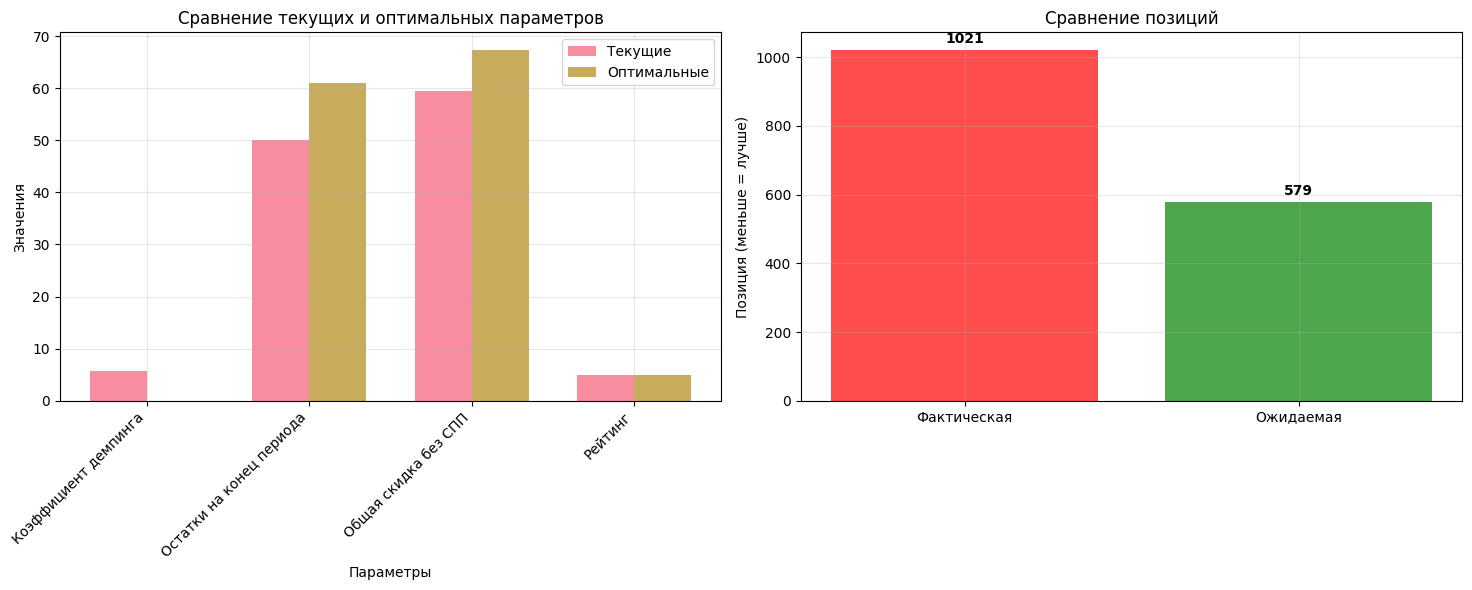


 ОПТИМИЗАЦИЯ ЗАВЕРШЕНА
 Товар может улучшить свою позицию на 442 пунктов
📈 Это улучшение на 43.2%


In [54]:
if controllable_features:
    optimal_params, optimal_predicted_position, improvement_from_actual, current_actual_rank = optimize_product_position(
        model=best_model,
        scaler=scaler,
        feature_names=X.columns,
        current_values=current_values,
        controllable_features=controllable_features,
        bounds=bounds,
        current_actual_rank=current_actual_rank,
        optimization_method='differential_evolution'
    )

    # Визуализация результатов
    if improvement_from_actual > 0:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # График изменения параметров
        features_to_plot = [f for f in controllable_features if f in optimal_params]
        current_vals = [current_values[f] for f in features_to_plot]
        optimal_vals = [optimal_params[f] for f in features_to_plot]

        x = np.arange(len(features_to_plot))
        width = 0.35

        axes[0].bar(x - width/2, current_vals, width, label='Текущие', alpha=0.8)
        axes[0].bar(x + width/2, optimal_vals, width, label='Оптимальные', alpha=0.8)
        axes[0].set_xlabel('Параметры')
        axes[0].set_ylabel('Значения')
        axes[0].set_title('Сравнение текущих и оптимальных параметров')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(features_to_plot, rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # График позиций
        positions = [current_actual_rank, optimal_predicted_position]
        labels = ['Фактическая', 'Ожидаемая']
        colors = ['red', 'green']

        axes[1].bar(labels, positions, color=colors, alpha=0.7)
        axes[1].set_ylabel('Позиция (меньше = лучше)')
        axes[1].set_title('Сравнение позиций')
        axes[1].grid(True, alpha=0.3)

        # Добавляем значения на столбцы
        for i, pos in enumerate(positions):
            axes[1].text(i, pos + max(positions) * 0.01, f'{pos:.0f}',
                        ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"\n ОПТИМИЗАЦИЯ ЗАВЕРШЕНА")
        print(f" Товар может улучшить свою позицию на {improvement_from_actual:.0f} пунктов")
        if current_actual_rank > 0:
            print(f"📈 Это улучшение на {(improvement_from_actual/current_actual_rank)*100:.1f}%")

else:
    print("\nНет управляемых параметров для оптимизации")
    print("Попробуйте изменить логику определения управляемых параметров")